In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
% matplotlib inline
#check to see if I can control how big each holdout set is, do with rms error
from sklearn.cross_validation import cross_val_score as cvs
from sklearn.cross_validation import KFold

#Import Data

In [3]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = '/home/ubuntu/data/D6_clean_features.csv', parse_dates = [0], index_col = 0)
print df_all[:5]

                       O3_ppb      UnixTime       e2v03  Temp         Rh  \
DATE (MM/DD/YYYY)_MST                                                      
2014-07-13 04:10:00        31  1.405225e+09  115.333333    24  47.200000   
2014-07-13 04:11:00        30  1.405225e+09  116.000000    24  47.300000   
2014-07-13 04:12:00        30  1.405225e+09  116.000000    24  47.300000   
2014-07-13 04:13:00        30  1.405225e+09  116.666667    24  47.366667   
2014-07-13 04:14:00        30  1.405225e+09  117.333333    24  47.366667   

                       Zenith Angle [degrees]  days from start  ref_o3_smooth  \
DATE (MM/DD/YYYY)_MST                                                           
2014-07-13 04:10:00                  96.31862                0             31   
2014-07-13 04:11:00                  96.16166                0             30   
2014-07-13 04:12:00                  96.00436                0             30   
2014-07-13 04:13:00                  95.84674                0

###Delete the unfiltered data

In [3]:
#df_all.drop(df_all.columns[[1]], axis=1, inplace=True)
#print df_all[:5]

##Declare whether to process raw or filtered data.

In [4]:
which_data = 0    #1 = filtered, 0 = raw
if which_data == 1:
    ref_column = 'O3_ppb'
    leave_out_pod = 'e2v03'
else:
    ref_column = 'ref_o3_smooth'
    leave_out_pod = 'pod_o3_smooth'

#Forward Selection for Random Forests


In [5]:
import random
import sys
from scipy import stats
from sklearn import linear_model

###Evaluate Critical Function


In [6]:
#make numpy arrays out of the training and holdout data
def df_subset(features, df_F, df_H):
    X_F = df_F[features].values
    X_H = df_H[features].values
    y_F = df_F[ref_column].values
    y_H = df_H[ref_column].values
    return X_F, y_F, X_H, y_H

import sklearn.ensemble as sk
#fit random forest and finds RSS
def crit_func(features, df_F, df_H):
    #Set up the random forest regression features
    rfr = sk.RandomForestRegressor(n_estimators=100, oob_score = True, n_jobs = -1)
    X_F, y_F, X_H, y_H = df_subset(features, df_F, df_H)
    #fit a linear regression on the training data
    rfr.fit(X_F, y_F)    
    #find the normalized RSS for the training and holdout data
    return np.mean((y_H - rfr.predict(X_H))**2), np.mean((y_F - rfr.predict(X_F))**2)

###Forward-selection using leave-one-day-out cross validation:

In [7]:
#define function that iteratively adds remaining features to best features to see which is most important
def forward_selection_step(b_f, features, df_F, df_H):
    #initialize min_RSS with a very large number
    min_MSE = sys.maxint
    next_feature = ''
    for f in features:
        #call the func that finds RSS, using arguments it's called with. First argument is best features + whichever one 
        #we're on in this iteration.
        MSE_H, MSE_F = crit_func(b_f + [f], df_F, df_H)
        if MSE_H < min_MSE:
            min_MSE = MSE_H
            next_feature = f
    return next_feature

In [8]:
def forward_selection_lodo(features, df):
    #initialize the best_features list with the base features to force their inclusion
    best_features = []
    #create a 'day' column in the dataframe by mapping the index column
    df['day'] = df.index.map(lambda dt: str(dt.month) + '-' + str(dt.day))
    days = df['day'].unique()
    
    MSE_F_list = []
    MSE_H_list = []
    while len(features) > 0:
        next_features = []
        #loop through every single day for the cross-validation
        for d in days:
            #Leave-one-out cross-validation. third agrument is training days (not selected day), fourth is holdout day. 
            f = forward_selection_step(best_features, features, df[df.day != d], df[df.day == d])
            #forward_selection_step returns the next feature, which is added to the next-features list. For every day, 
            #a different possible best feature is chosen, and they're all put in this list
            next_features += [f]
        #take the mode of the best features list from all cross-validation days (vote)
        next_feature = stats.mode(next_features)[0][0]
        #add the chosed best feature to the list
        best_features += [next_feature]
        #remove the chosen feature from the list
        features.remove(next_feature)
        
        #prints the result of the vote- shows you how many days voted for that feature
        print stats.mode(next_features)
        
        #initizlize the holdout and training RSS
        MSE_H = 0
        MSE_F = 0

        #So that we can plot them below, calculate the training and holdout RSS for each step.
        #take the mean RSS for all of the possible holdout days (giving cross-validation error)
        for d in days:
            MSE_H_temp, MSE_F_temp= crit_func(best_features, df[df.day != d], df[df.day == d])
            MSE_H += MSE_H_temp
            MSE_F += MSE_F_temp
            
        MSE_H_list += MSE_H
        MSE_F_list += MSE_F
        print 'MSE Training:' + str(MSE_F)
        print 'MSE Holdout:' + str(MSE_H)

    #drop the day column
    df.drop('day', axis=1, inplace=True)
    return best_features, MSE_F_list, MSE_H_list

####Try it!

In [9]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
#this lets you leave out anything you want
leave_out = ['O3_ppb','ref_o3_smooth','Zenith Angle [degrees]','days from start','UnixTime',leave_out_pod]
#make a new list of features without the ones in leave_out
features = [f for f in features if f not in leave_out]

In [11]:
fs_features, MSE_F, MSE_H = forward_selection_lodo(features, df_all[[ref_column] + features].dropna())
print fs_features

(array(['O3_sq'], 
      dtype='|S32'), array([ 4.]))
MSE Training:790.486577832
MSE Holdout:996.812259013
(array(['03_mult_temp_sq'], 
      dtype='|S32'), array([ 2.]))
MSE Training:85.278261084
MSE Holdout:724.052530456
(array(['03_mult_rh_&_temp_sq'], 
      dtype='|S32'), array([ 2.]))
MSE Training:29.45809831
MSE Holdout:644.673731511
(array(['03_mult_rh_&_temp_cu'], 
      dtype='|S32'), array([ 1.]))
MSE Training:29.4007177498
MSE Holdout:669.237753216


KeyboardInterrupt: 

In [ ]:
x = range(1, len(MSE_F)+1)
plt.figure()
plt.plot(x, MSE_F, 'ro-')
plt.ylabel('Training MSE')
plt.figure()
plt.plot(x, MSE_H, 'bo-')
plt.xlabel('Number of Features')
plt.ylabel('Holdout MSE')

#Enter the number of good features to use for regressions.

In [26]:
fs_features = features
num_good_feat = 3
fs_features[:num_good_feat]

['e2v03', 'Temp', 'Rh']

#Check Residuals

In [27]:
df_fit = df_all[fs_features[:num_good_feat] + [ref_column]].dropna()
X = df_fit[fs_features[:num_good_feat]].values
y = df_fit[ref_column].values

In [28]:
rfr = sk.RandomForestRegressor(n_estimators=100, oob_score = True, n_jobs = -1)
rfr.fit(X, y)  
df_fit['O3_fit'] = rfr.predict(X)

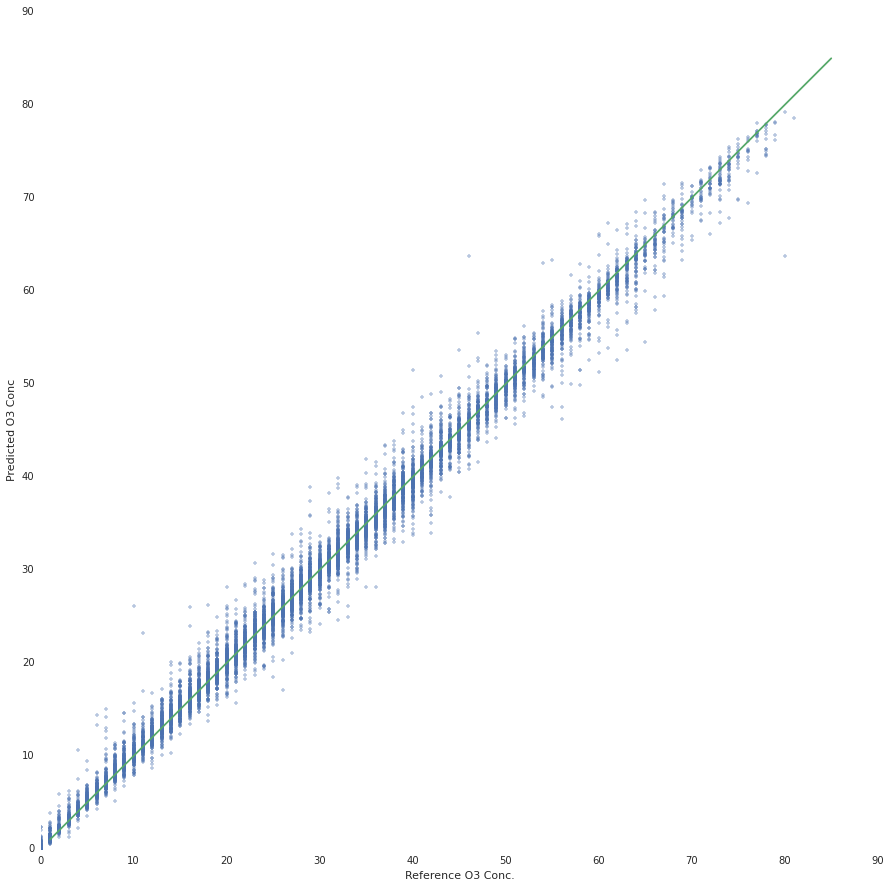

In [29]:
plt.figure(figsize = (15,15))
plt.plot(df_fit[ref_column],df_fit.O3_fit,linestyle = '',marker = '.',alpha = 0.4)
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85])

In [30]:
print ("Residual sum of squares: %.2f" %
        np.mean((df_fit[ref_column] - df_fit.O3_fit) ** 2))

Residual sum of squares: 1.97


In [31]:
#find the residuals
lin_resid = df_fit[ref_column] - df_fit.O3_fit

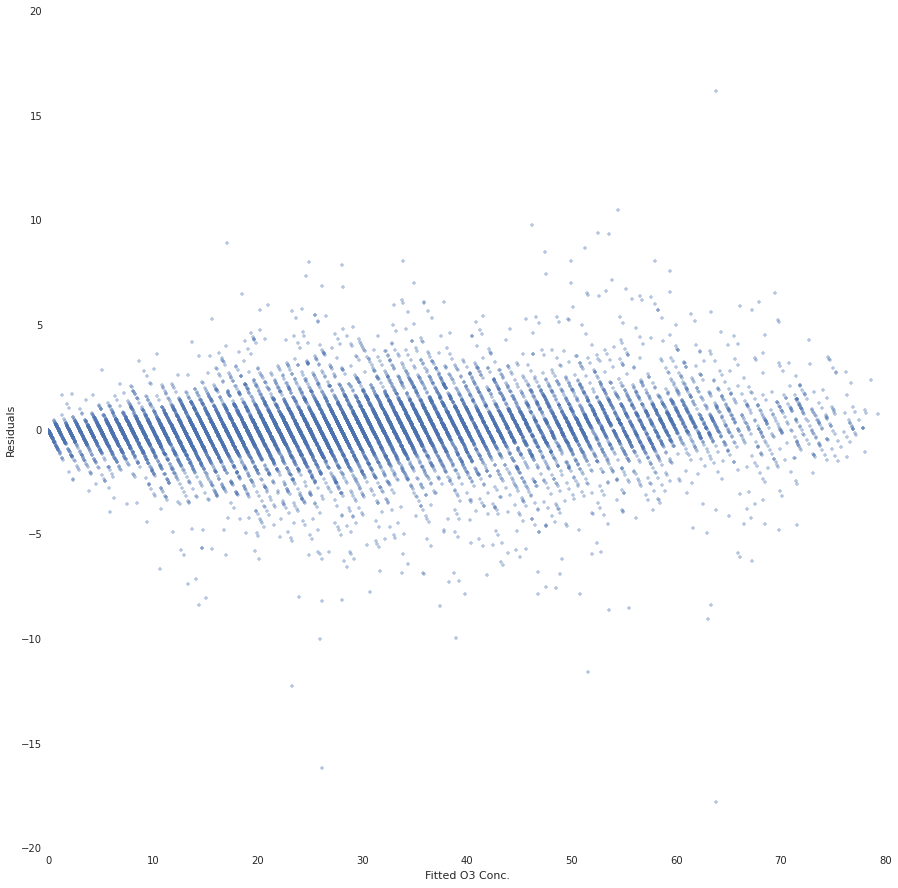

In [32]:
#plot the residuals to check for non-linearity of response predictor
plt.figure(figsize = (15,15))
plt.plot(df_fit.O3_fit,lin_resid,linestyle = '',marker = '.',alpha = 0.4)
#plt.plot([0,0],[70,0])
plt.xlabel('Fitted O3 Conc.')
plt.ylabel('Residuals')

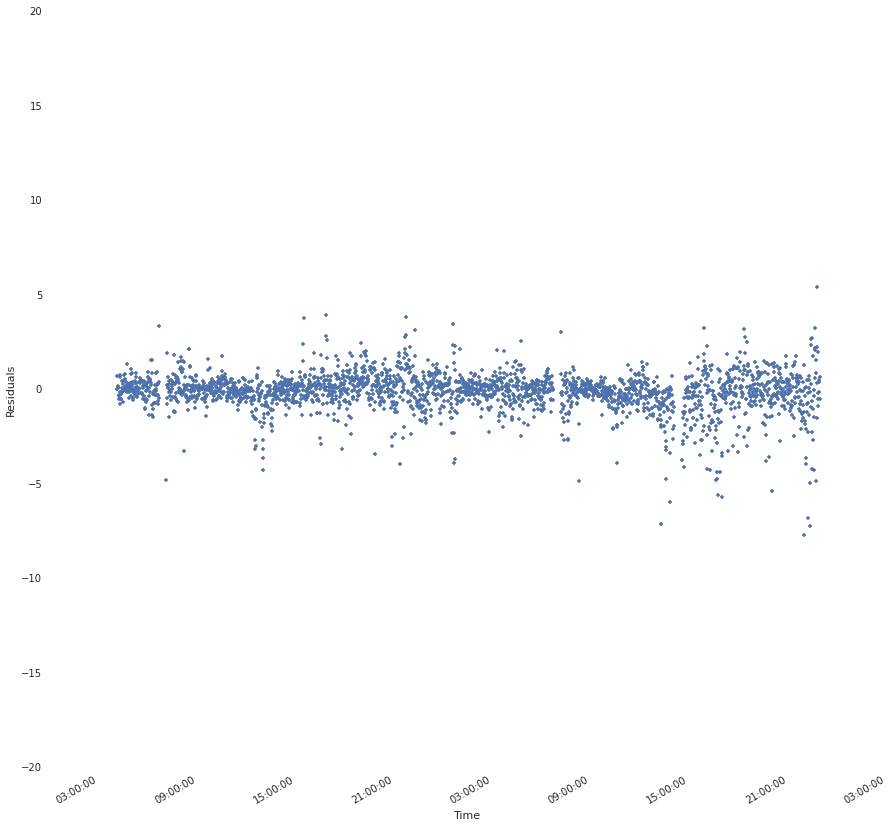

In [42]:
plt.figure(figsize = (15,15))
lin_resid.plot(linestyle = '',marker = '.', xlim=['2014-07-13 00:00:00', '2014-07-15 03:00:00'])
#plt.plot([0,0],[70,0])
plt.xlabel('Time')
plt.ylabel('Residuals')

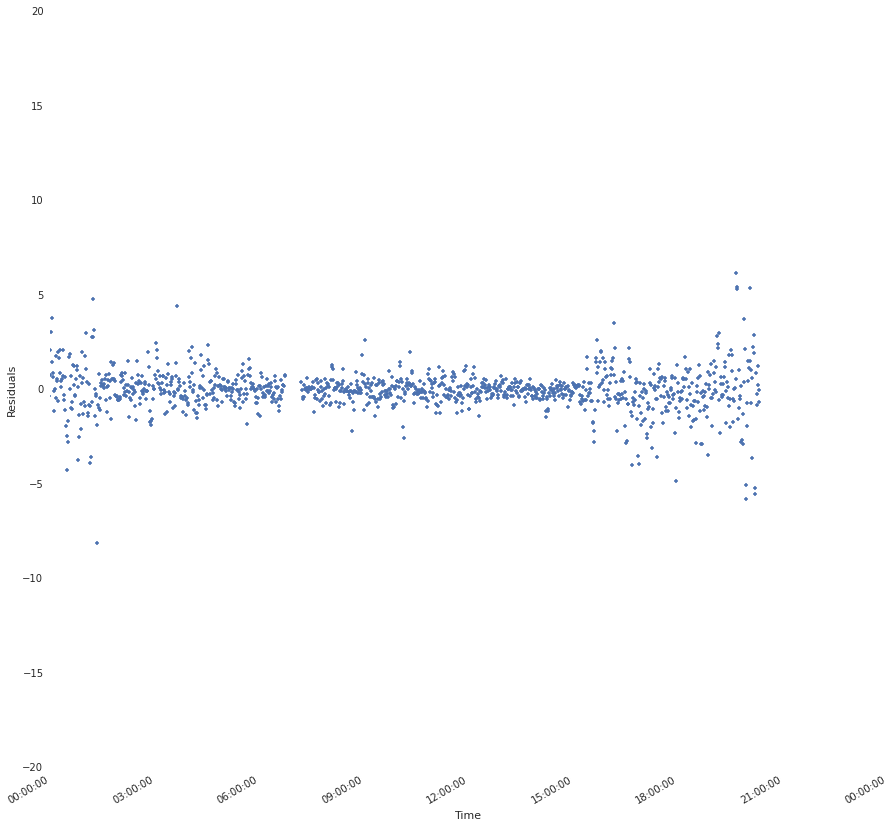

In [35]:
plt.figure(figsize = (15,15))
lin_resid.plot(linestyle = '',marker = '.', xlim=['2014-08-29 00:00:00', '2014-08-30 00:00:00'])
#plt.plot([0,0],[70,0])
plt.xlabel('Time')
plt.ylabel('Residuals')

In [44]:
# Explained variance score: 1 is perfect prediction
print ('Variance score: %.2f' % rfr.score(X, y))

Variance score: 0.99


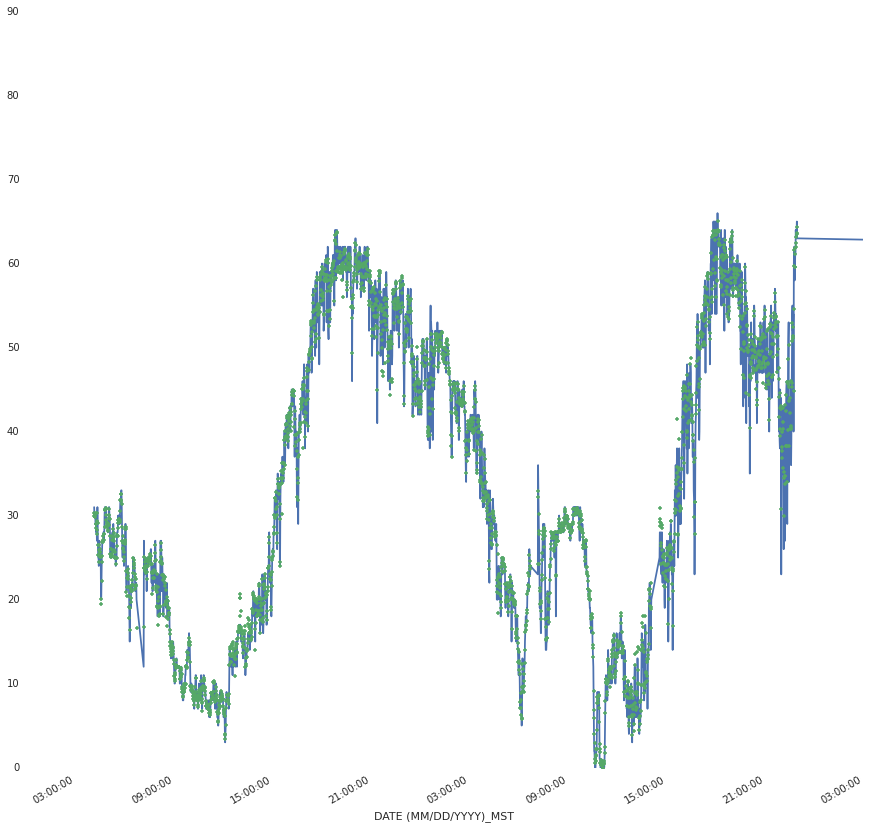

In [47]:
plt.figure(figsize = (15,15))
df_fit[ref_column].plot()
df_fit.O3_fit.plot(marker = '.',linestyle = '', xlim=['2014-07-13 00:00:00', '2014-07-15 03:00:00'])

In [71]:
fs_features

['e2v03',
 'Temp',
 'Rh',
 'rh_int_90',
 'rh_int_75',
 'rh_int_60',
 'rh_int_45',
 'rh_int_30',
 'temp_int_90',
 'temp_int_75',
 'temp_int_60',
 'temp_int_45',
 'temp_int_30',
 'O3_cu',
 'ln_O3',
 'temp_sq',
 'temp_cu',
 'ln_temp',
 'ln_temp_int_90',
 'rh_sq',
 'rh_cu',
 'ln_rh',
 'ln_rh_int_90',
 '03_mult_temp',
 '03_mult_temp_cu',
 'ln_03_mult_temp',
 '03_mult_rh',
 '03_mult_rh_sq',
 '03_mult_rh_cu',
 'ln_03_mult_rh',
 'temp_mult_rh',
 'temp_mult_rh_sq',
 'temp_mult_rh_cu',
 'ln_temp_mult_rh',
 '03_mult_rh_&_temp',
 'ln_03_mult_rh_&_temp_cu']

In [48]:
#fs_features = ['e2v03','Temp','Rh']
num_good_feat = len(fs_features)

#Random Forest

In [49]:
#make numpy arrays out of the training and holdout data
def make_numpy_arrays_for_tr_and_holdout(features, df_T, df_H):
    X_T = df_T[features].values
    X_H = df_H[features].values
    y_T = df_T['O3_ppb'].values
    y_H = df_H['O3_ppb'].values
    return X_T, y_T, X_H, y_H

###Choose to run random forest defaults or a range of options.

In [50]:
#0 = default, 1 = other
options = 0

In [84]:
import sklearn.ensemble as sk
i_max = 1 # max features
j_max = 1 # max depth
i_min = 0
j_min = 0

#fit random forest and finds MSE
def fit_rfr_and_find_MSE(features, df_F, df_H,d):
    #initialize the numpy array that will hold the test-mse data
    mse_array_test = np.zeros((i_max,j_max))
    mse_array_train = np.zeros((i_max,j_max))
    
    #loop through all combinations of max_features and max_depth
    if options == 0:
        rfr = sk.RandomForestRegressor(n_estimators=250, oob_score = True, n_jobs = -1)
        forest = sk.RandomForestClassifier(n_estimators=250, random_state=0)
                        
        #call the r=function that defines the trainig and holdout data
        X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])
        
        #fit a linear regression on the training data
        rfr.fit(X_T, y_T)  
        
        plot_importance(rfr, forest)
            
        print d,'Holdout MSE: ' + int(np.mean((y_H - rfr.predict(X_H))**2))
        
    else:
        for i in range(i_min,i_max):
            j = j_min
            while j < j_max:
                #Set up the random forest regression features
                rfr = sk.RandomForestRegressor(n_estimators=250, oob_score = True, n_jobs = -1, max_features = i+1, max_depth = j+1)
                #forest = sk.RandomForestClassifier(n_estimators=100, random_state=0)
                        
                #call the r=function that defines the trainig and holdout data
                X_T, y_T, X_H, y_H = make_numpy_arrays_for_tr_and_holdout(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])
                
                #fit a linear regression on the training data
                rfr.fit(X_T, y_T)  
                #plot_importance(rfr, forest)
            
                #add the mse for each i and j to the 2D array (i is on one axis, j is on the other, and mse is a grid)
                mse_array_test[i,j] = int(np.mean((y_H - rfr.predict(X_H))**2))
                mse_array_train[i,j] = int(np.mean((y_T - rfr.predict(X_T))**2))
            
                print d,i,j,int(np.mean((y_H - rfr.predict(X_H))**2))
                j += 10
               
    #find the MSE for the training and holdout data
    return mse_array_test, mse_array_train

In [85]:
def plot_importance(rfr,forest):
    importances = rfr.feature_importances_
    std = np.std([rfr.feature_importances_ for rfr in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    for f in range(len(fs_features)):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    #Plot the feature importances of the forest
    plt.figure(figsize=(15,5))
    plt.title("Feature importances")
    plt.bar(range(len(fs_features)), importances[indices],  color="r", align="center")
    plt.xticks(range(len(fs_features)), indices)
    plt.xlim([-1, len(fs_features)])
    plt.show()

Feature ranking:
1. feature 14 (0.166082)
2. feature 13 (0.156072)
3. feature 0 (0.149148)
4. feature 29 (0.066932)
5. feature 26 (0.066039)
6. feature 27 (0.062694)
7. feature 28 (0.053231)
8. feature 9 (0.023403)
9. feature 8 (0.021644)
10. feature 12 (0.021494)
11. feature 35 (0.020189)
12. feature 11 (0.020024)
13. feature 10 (0.019502)
14. feature 34 (0.017659)
15. feature 15 (0.012196)
16. feature 18 (0.010747)
17. feature 30 (0.010624)
18. feature 31 (0.010593)
19. feature 33 (0.009865)
20. feature 32 (0.009824)
21. feature 17 (0.009611)
22. feature 16 (0.008423)
23. feature 1 (0.007996)
24. feature 5 (0.004522)
25. feature 3 (0.004358)
26. feature 6 (0.004272)
27. feature 4 (0.004243)
28. feature 7 (0.004234)
29. feature 22 (0.003832)
30. feature 25 (0.003576)
31. feature 24 (0.003482)
32. feature 23 (0.003376)
33. feature 19 (0.002773)
34. feature 2 (0.002536)
35. feature 20 (0.002408)
36. feature 21 (0.002397)


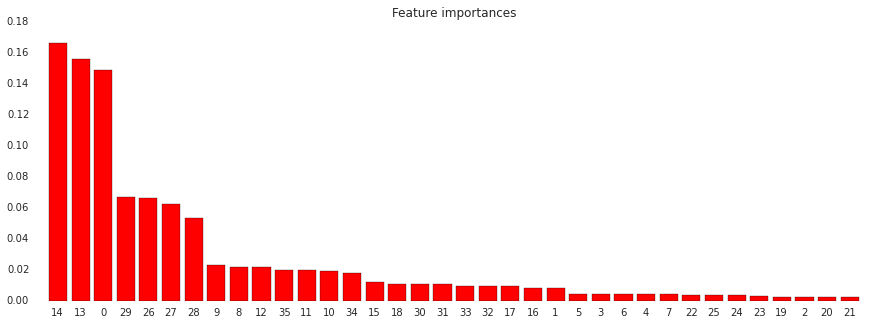

7-13

TypeError: cannot concatenate 'str' and 'int' objects

In [86]:
# define the dataset
import sklearn.preprocessing as pp
#Set up the feature scaling, so that every feature of the data goes from 0 to 1
mms = pp.MinMaxScaler(feature_range=(0, 1), copy=True)
df_fit_sc = df_all[fs_features].apply(lambda x: mms.fit_transform(x))

df_fit = pd.concat([df_fit_sc, df_all.O3_ppb], axis = 1)

#create a 'day' column in the dataframe by mapping the index column
df_fit['day'] = df_fit.index.map(lambda dt: str(dt.month) + '-' + str(dt.day))
days = df_fit['day'].unique()
        
#initialize the holdout and training RSS
MSE_T = []
MSE_H = [] 
day_date = []
count = 1
count_append = []
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
    MSE_H_day, MSE_T_day = fit_rfr_and_find_MSE(fs_features, df_fit[df_fit.day != d], df_fit[df_fit.day == d],d)
    day_date.append(d)
    count_append.append(count)
    if count == 1:
        MSE_H = MSE_H_day
        MSE_T = MSE_T_day
    else:
        MSE_H = np.dstack((MSE_H,MSE_H_day))
        MSE_T = np.dstack((MSE_T,MSE_T_day))
        
    count +=1

#drop the day column
df_fit.drop('day', axis=1, inplace=True)

In [78]:
if options == 1:
#first array is  [[day 1, day 2, ..., day n (i = 0 & j = 0)] [day 1, day 2, ..., day n (i = 0, j = 1)] [day 1, day 2, ..., day n(i = 0, j = n)]
#second array is [[day 1, day 2, ..., day n (i = 1 & j = 0)] [day 1, day 2, ..., day n (i = 1, j = 1)] [day 1, day 2, ..., day n(i = 1, j = n)]
#nth array is [[day 1, day 2, ..., day n (i = n & j = 0)] [day 1, day 2, ..., day n (i = n, j = 1)] [day 1, day 2, ..., day n(i = n, j = n)]
    print MSE_H

In [79]:
if options == 1:
    MSE_H_per_day = MSE_H.mean(axis=2, dtype = int)
    print MSE_H_per_day

In [75]:
#np.ndarray.nonzero(MSE_H_per_day)

In [81]:
if options == 1:    
    fig = plt.figure(figsize=(20, 20))

    ax = fig.add_subplot(111)
    ax.set_title('colorMap')
    imgplot = plt.imshow(MSE_H_per_day)
    imgplot.set_cmap('hot')
    #imgplot.set_clim(60,71)
    ax.set_aspect('equal')

    plt.colorbar(orientation='vertical')
    plt.show()
    plt.xlabel('Maximum Tree Depth')
    plt.ylabel('Maximum Features at Each Split')

In [82]:
if options == 1:
    min_MSE_H = MSE_H_per_day.min()
    i,j = np.where(MSE_H_per_day == min_MSE_H)
    i = i + 1
    j = (j + 1)*5
    print 'Max features = ' + str(i)
    print 'Max depth = ' + str(j)
    print 'MSE for the holdout data = ' + str(min_MSE_H)

In [ ]:
print 'mean MSE = ' + str(np.mean(MSE_H))
print 'Daily MSE = ' + str(MSE_H)

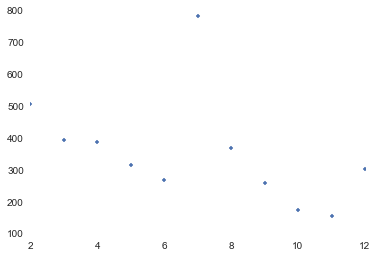

In [169]:
plt.plot(count_append, MSE_H, marker = '.', linestyle = ' ')

In [236]:
rfr.feature_importance_

NameError: name 'rfr' is not defined

In [3]:
import sklearn.ensemble as sk

#Set up the random forest regression features
rfr = sk.RandomForestRegressor(n_estimators=250, oob_score = True)
#max_features = 'sqrt',

import sklearn.preprocessing as pp
#Set up the feature scaling, so that every feature of the data goes from 0 to 1
mms = pp.MinMaxScaler(feature_range=(0, 1), copy=True)

In [4]:
#change 
#define the training data
df_fit = df_all[fs_features[:4] + ['O3_ppb']].dropna()
X = df_fit[fs_features[:4]].values
y = df_fit['O3_ppb'].values

NameError: name 'df_all' is not defined

In [575]:
from sklearn.feature_selection import f_regression
f_regression(X, y)

(array([  46.08990206,    5.93959419,    9.63208028,  241.13778426]),
 array([  6.70400405e-11,   1.54250389e-02,   2.10702293e-03,
          1.09048169e-39]))

In [576]:
reg = rfr.fit(X, y) #X is training, y is target/reference

In [511]:
from scipy import stats
stats_pearson = stats.pearsonr(X[:,0],y)
stats_pearson[1]

1.3986383496229234e-19

In [523]:
#find the importance of each feature in the regression
rfr.feature_importances_

array([ 0.07082218,  0.27023038,  0.16056044,  0.498387  ])

In [111]:
rfr.oob_score_

0.86388746461504862

In [95]:
rfr.score(X,y)

0.98916752433129396

###Cross-Validation Error

In [2]:
#check to see if I can control how big each holdout set is, do with rms error
from sklearn.cross_validation import cross_val_score as cvs
from sklearn.cross_validation import KFold

#Get the random forest classifier results
clf = sk.RandomForestClassifier(n_estimators=250, oob_score = 'true')
#get the cross-validation scores
scores = cvs(clf, X, y, cv = 10, scoring='mean_squared_error')
#scoring -> mean_squared_error, r2
#cross_val = KFold(clf, shuffle = True)
abs(scores.mean())

NameError: name 'sk' is not defined

In [478]:
scores

array([ -84.26954863,  -30.68985322,  -38.53316162,  -28.74367294,
        -49.92945787,  -75.08769634,  -34.05052493,  -30.94719472,
        -31.51888668, -331.79333333])

####Apply the calibration to the data 

In [1]:
#Set the predictor variable. 
y_pred = rfr.predict(X)
print y-y_pred

NameError: name 'rfr' is not defined

In [36]:
#Calculate the MSE
mse = np.mean((y - y_pred)**2)
print mse

1.45076424698


In [37]:
#make a copy of the reference & pod data to manipulate
df_fit_copy = df_fit.copy()
df_fit[:5]

,e2v03,Rh,Temp,UnixTime,O3_mult_temp15,03_mult_temp,O3_mult_Rh45,temp_mult_rh,O3_ppb
Date,,,,,,,,,
2014-07-07 21:52:00,103.333333,10.633333,43.833333,1.404770e+09,4674.066667,4529.366667,1070.000000,466.093333,32
2014-07-07 21:53:00,104.333333,10.600000,43.800000,1.404770e+09,4708.966667,4569.800000,1046.766667,464.280000,31
2014-07-07 21:54:00,98.000000,10.600000,43.666667,1.404770e+09,4419.800000,4279.366667,996.333333,462.866667,30
2014-07-07 21:55:00,95.666667,10.600000,43.600000,1.404770e+09,4301.833333,4171.066667,985.333333,462.160000,30
2014-07-07 21:56:00,93.666667,10.700000,43.466667,1.404770e+09,4205.633333,4071.366667,964.766667,465.093333,32


In [38]:
#change the reference data column in the new matrix to the predicted value
df_fit_copy['O3_ppb'] = y_pred

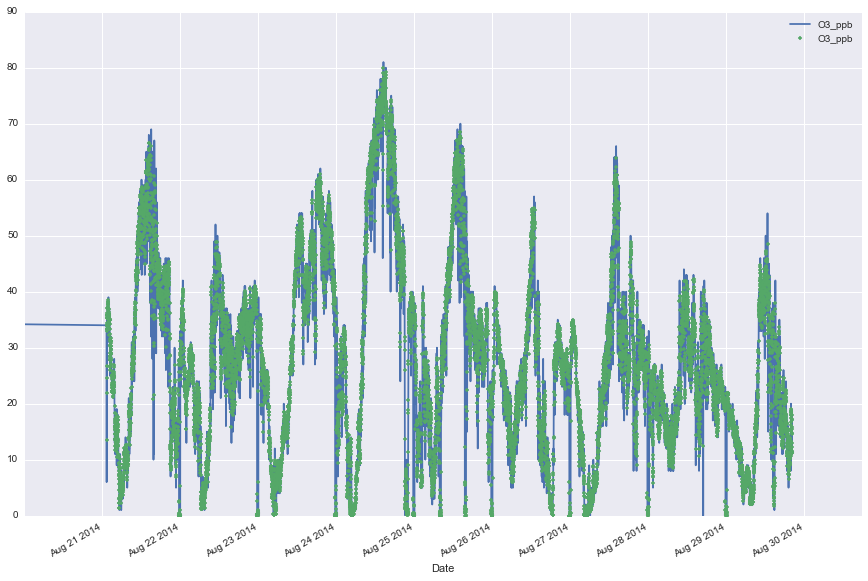

In [39]:
#plot the reference data
df_fit['O3_ppb'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_fit_copy['O3_ppb'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10), xlim=['2014-08-20 00:21:57', '2014-08-30 17:41:00'])
#plt.show()
#, xlim=['2014-07-07 00:21:57', '2014-07-11 17:41:00']

##Plot the reference data versus the predicted data.

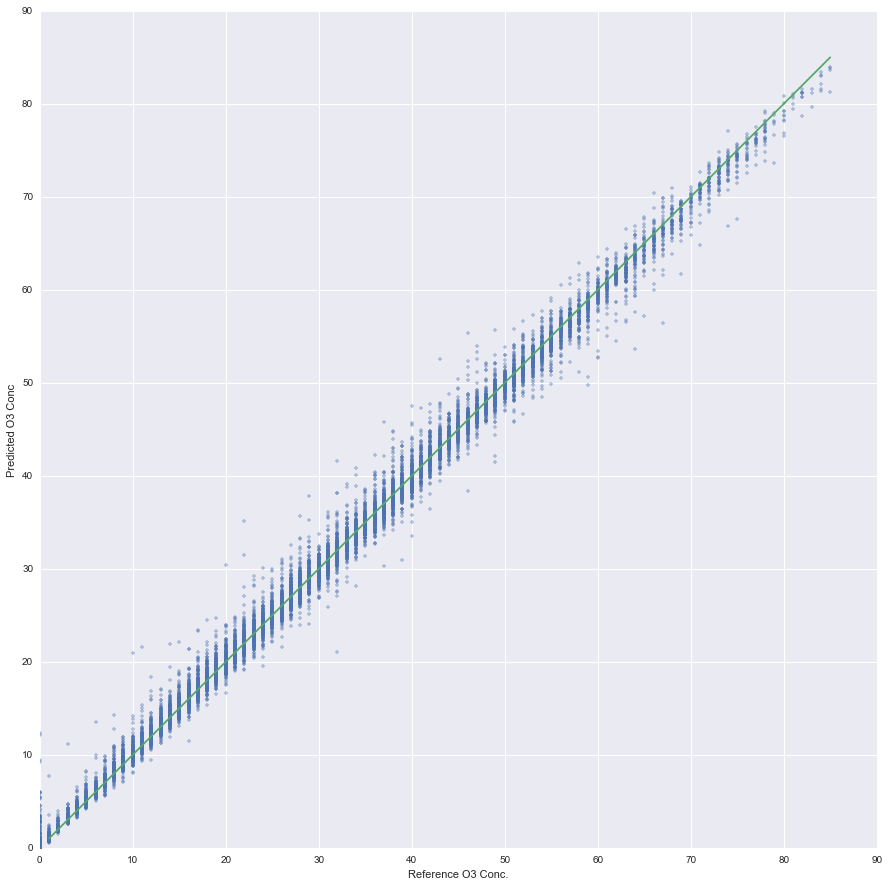

In [40]:
plt.figure(figsize = (15,15))
plt.plot(y,y_pred,linestyle = '',marker = '.',alpha = 0.4)
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85])

#Ridge Regression

In [198]:
fs_features = ['e2v03','Temp','Rh']

In [51]:
from sklearn.linear_model import Ridge

#define the training data
df_fit = df_all[fs_features + ['O3_ppb']].dropna()
X = df_fit[fs_features].values
y = df_fit['O3_ppb'].values
#print df_fit[:5]

###Find the best lambda value using cross-validation

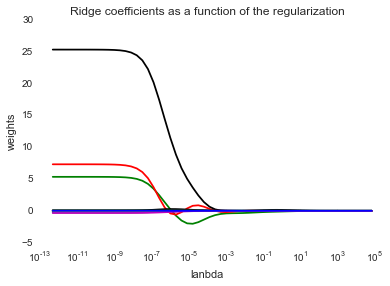

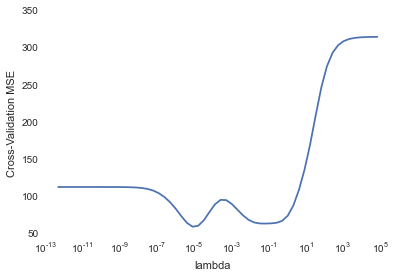

In [52]:
MSE_ridge = []
lambda_ridge = []
i = 0.0000000000005
n = 1
coefs = []
while i < 100000:
    ridge = Ridge(alpha=i, normalize = True)
    #fit the ridge regression for the lambda
    ridge.fit(X, y)
    #get the cross-validation scores
    scores = cvs(ridge, X, y, cv = 10, scoring='mean_squared_error')
    #record the score
    MSE_ridge.append(-scores.mean())
    #record the run number
    lambda_ridge.append(i)    
    coefs.append(ridge.coef_)
    i = i*2
    n += 1
        
#plot the coefficients     
ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(lambda_ridge, coefs)
ax.set_xscale('log')
plt.xlabel('lanbda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.show()  
    
#find the lambda value that produces the lowest cross-validation MSE    
best_lambda = lambda_ridge[MSE_ridge.index(min(MSE_ridge))]

    
#plot the results
plt.plot(lambda_ridge, MSE_ridge)
ax = plt.gca()
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('Cross-Validation MSE')

###Re-run the ridge regression with the lambda chosen above

In [53]:
ridge = Ridge(alpha=best_lambda, normalize = True)
#fit the ridge regression for the lambda
ridge.fit(X, y)
#get the cross-validation scores
scores = cvs(ridge, X, y, cv = 10, scoring='mean_squared_error')
print abs(scores.mean())

60.8195433503


####Define a function that finds the ridge regression for each day

In [54]:
#fit random forest and finds RSS
def rand_for_cv(features, df_F, df_H):
    
    #Set up the random forest regression features
    ridge = Ridge(alpha=best_lambda, normalize = True)
    
    #call the r=function that defines the trainig and holdout data
    X_T, y_T, X_H, y_H = df_subset(features, df_fit[df_fit.day != d], df_fit[df_fit.day == d])
    
    #fit a linear regression on the training data
    ridge.fit(X_T, y_T)  
    
    #find the normalized MSE for the training and holdout data
    return np.mean((y_H - ridge.predict(X_H))**2), np.mean((y_T - ridge.predict(X_T))**2)

####Find the MSE by holding out one day 

In [55]:
#define the dataset
df_fit = df_all[fs_features[:4] + ['O3_ppb']].dropna()

#create a 'day' column in the dataframe by mapping the index column
df_fit['day'] = df_fit.index.map(lambda dt: str(dt.month) + '-' + str(dt.day))
days = df_fit['day'].unique()
        
#initizlize the holdout and training RSS
MSE_T = []
MSE_H = [] 
day_date = []
count = 1
count_append = []
#Calculate the training and holdout RSS for each step.
#take the mean MSE for all of the possible holdout days (giving cross-validation error)
for d in days:
    MSE_H_temp, MSE_T_temp = rand_for_cv(fs_features[:4], df_fit[df_fit.day != d], df_fit[df_fit.day == d])
    MSE_H.append(MSE_H_temp)
    MSE_T.append(MSE_T_temp)
    day_date.append(d)
    count +=1
    count_append.append(count)

#drop the day column
df_fit.drop('day', axis=1, inplace=True)

In [56]:
print 'mean MSE = ' + str(np.mean(MSE_H))
print 'Daily MSE = ' + str(MSE_H)

mean MSE = 68.843701133
Daily MSE = [166.42549162569745, 45.71346470755666, 81.950389105111952, 52.925227911797663, 27.499125629360215, 26.374277233405675, 49.53462063422959, 62.805699033777472, 106.36501431638098]


In [205]:
best_lambda = 0

In [201]:
ridge.coef_

array([ -1.38705318e-09,  -4.92507378e-12,  -1.85318810e-09,
         4.64340544e-10,   4.10544706e-22,  -3.58070150e-06,
         1.34886016e-14,   8.80120624e-12,  -1.27783541e-07,
        -1.71115427e-07,  -1.03623782e-09,   8.80024292e-08,
         3.88314633e-18,   1.25616582e-08,  -5.34821807e-08,
        -3.78603679e-08,   9.75705943e-10,   7.25231759e-08,
         1.10789132e-15,  -7.01709528e-16,   1.04489726e-09,
         1.81819039e-07,   4.22049747e-10,   9.88201693e-08,
         5.72219366e-10,  -3.06932668e-07,   2.20837108e-06,
        -3.29966503e-09,   9.73455811e-08,   2.54526837e-08,
         2.97295416e-10])

In [202]:
#Set the predictor variable. 
y_pred_ridge = ridge.predict(X)
print y-y_pred_ridge

[ -0.16161649   1.83835761  -1.16164108 ..., -29.16190474 -29.16192494
 -29.16191295]


In [203]:
#Calculate the training MSE
mse = np.mean((y - y_pred_ridge)**2)
print mse

303.293075673


In [204]:
#make a copy of the reference & pod data to manipulate
df_fit_ridge = df_fit.copy()
df_fit_ridge[:5]

,03_mult_temp45,03_mult_temp_sq,03_mult_temp30,03_mult_rh_&_temp,03_mult_rh_&_temp_cu,Temp,temp_mult_rh_sq,O3_cu,temp_int_45,temp_int_30,...,03_mult_rh45,rh_int_30,03_mult_rh30,temp_int_15,Rh,03_mult_temp15,temp_mult_rh,rh_sq,rh_cu,ref_o3_smooth
DATE (MM/DD/YYYY)_MST,,,,,,,,,,,,,,,,,,,,,
2014-07-10 21:10:00,193950.6272,18599011.63,127044.5048,50334.86980,1.275280e+14,44.200000,137289985.0,928897.9213,1987.780952,1302.066667,...,49044.51088,336.077381,32791.55017,626.850000,11.671429,61162.65000,515.877143,136.222245,1589.908201,29
2014-07-10 21:11:00,190016.0944,17758779.28,124463.0167,49305.16500,1.198610e+14,44.050000,136897438.9,875551.9630,1986.230952,1301.007143,...,48110.31111,336.421429,32184.31667,626.192857,11.700000,59905.78333,515.385000,136.890000,1601.613000,31
2014-07-10 21:12:00,190513.9429,17819011.87,124784.5714,49026.88653,1.178430e+14,43.971429,133195405.1,884736.0000,1984.520238,1299.839286,...,48314.28571,336.728571,32325.94286,625.382143,11.614286,60036.68571,510.696735,134.891633,1566.669962,28
2014-07-10 21:13:00,196849.0578,18935996.28,128934.5561,50167.16676,1.262580e+14,43.828571,129002590.0,978724.1254,1982.652381,1298.621429,...,50003.35884,336.907143,33450.06633,624.471429,11.528571,62001.09184,505.280816,132.907959,1532.238901,24
2014-07-10 21:14:00,203724.2449,20256612.78,133443.1837,52208.52245,1.423060e+14,43.757143,130773828.5,1088186.5890,1980.652381,1297.364286,...,51821.87755,336.885714,34651.10204,623.471429,11.600000,64128.48980,507.582857,134.560000,1560.896000,27


In [205]:
#plot the reference data
df_fit['O3_ppb'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_fit_ridge['O3_ppb'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10), xlim=['2014-07-07 00:00:00', '2014-07-11 00:00:00'])

KeyError: 'O3_ppb'

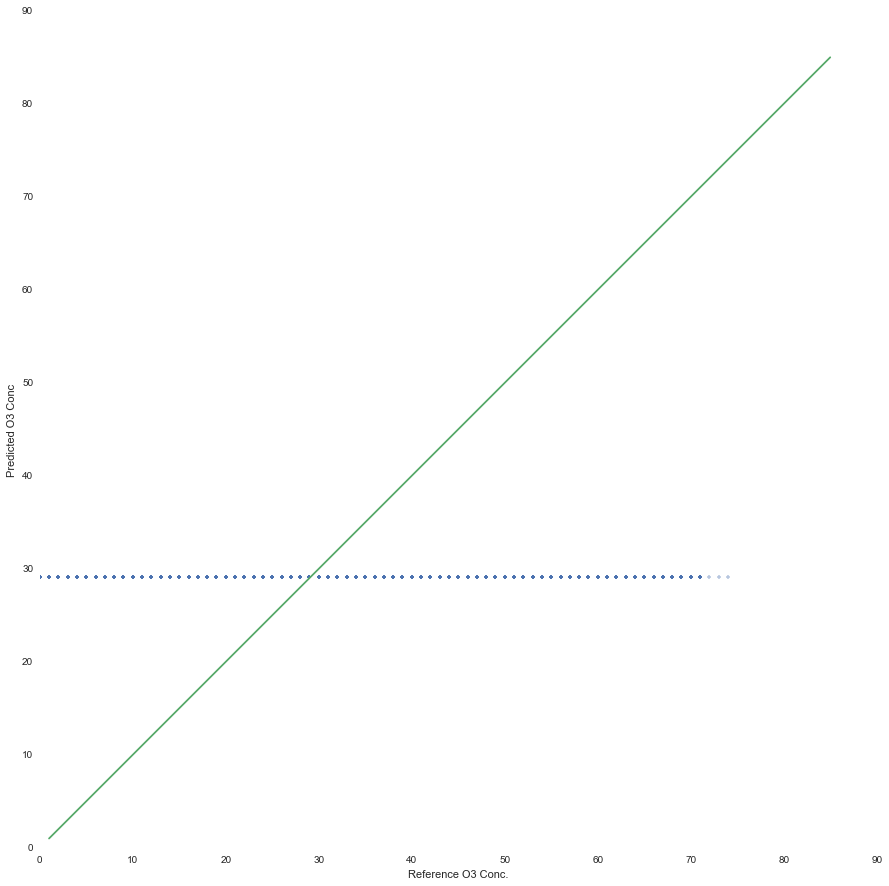

In [206]:
plt.figure(figsize = (15,15))
plt.plot(y,y_pred_ridge,linestyle = '',marker = '.',alpha = 0.4)
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85])

#Extremely Randomized Trees Regressor

In [192]:
efr = sk.ExtraTreesRegressor(n_estimators = 150, oob_score = True, bootstrap = True)

In [193]:
reg = efr.fit(X, y) 

In [194]:
efr.oob_score_

0.96838666081004265

In [195]:
efr.score(X,y)

0.99561305889037399

In [196]:
from sklearn.cross_validation import cross_val_score as cvs

#Get the random forest classifier results
clf = sk.ExtraTreesClassifier(n_estimators=150)
#get the cross-validation scores
scores = cvs(clf, X, y, cv = 10, scoring='r2')
scores.mean() 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:413: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


0.79840583027411627

In [197]:
scores

array([ 0.38052729,  0.85731779,  0.86681182,  0.94910679,  0.97095914,
        0.94401147,  0.92781704,  0.90514934,  0.92024377,  0.26211385])

In [198]:
#find the importance of each feature in the regression
efr.feature_importances_

array([ 0.04421643,  0.02073118,  0.02539547,  0.01631341,  0.01417942,
        0.0590038 ,  0.04190763,  0.01189003,  0.07765417,  0.05409885,
        0.05089661,  0.01058592,  0.01389787,  0.01516702,  0.05461709,
        0.02061267,  0.01402753,  0.06815952,  0.01460048,  0.02271306,
        0.01807739,  0.03076036,  0.03054903,  0.04368726,  0.02123209,
        0.04288161,  0.03800581,  0.01727528,  0.04095892,  0.03329685,
        0.03260725])

In [199]:
#Set the predictor variable. 
efc_pred = efr.predict(X)

In [200]:
#make a copy of the reference & pod data to manipulate
df_efc_pred = df_all.copy()

#change the reference data column in the new matrix to the predicted value
df_efc_pred['O3_ref'] = efc_pred

#plot the reference data
df_all['O3_ref'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_efc_pred['O3_ref'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10))
#plt.show()

KeyError: 'O3_ref'

##Compare the random forest and extra trees regressions

In [ ]:
plt.figure(figsize = (15,15))
plt.plot(y,efc_pred,linestyle = '',marker = '.',alpha = 0.7,label = 'Ext. For.')
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85], label = '1-to-1 line')
plt.plot(y,y_pred,linestyle = '',marker = '.',alpha = 0.2, label = 'Ran. For.')
plt.legend(loc='upper left', frameon = True)

#AdaBoost

In [ ]:
import sklearn.tree as tsk

#dt1 = tsk.DecisionTreeRegressor(max_depth=4) create single tree
ada = sk.AdaBoostRegressor(n_estimators = 175, learning_rate = 3)
staged_score = (X,y)

In [ ]:
#dt1_reg = dt1.fit(X,y)   
ada_reg = ada.fit(X,y)

In [ ]:
ada_reg.score(X,y)

In [ ]:
#Get the Ada Boost classifier results
ada_cv = sk.AdaBoostClassifier(n_estimators = 175, learning_rate = 3)
#get the cross-validation scores
scores = cvs(ada_cv, X, y, cv = 10, scoring='r2')
scores.mean() 

In [ ]:
#y_dt1 = dt1_reg.predict(X)
y_ada = ada_reg.predict(X)

#Set the predictor variable. 
ada_pred = ada_reg.predict(X)

#make a copy of the reference & pod data to manipulate
df_ada_pred = df_all.copy()

#change the reference data column in the new matrix to the predicted value
df_ada_pred['O3_ref'] = ada_pred

#plot the reference data
df_all['O3_ref'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_ada_pred['O3_ref'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10))
#plt.show()

In [ ]:
plt.figure(figsize = (15,15))
plt.plot(y,efc_pred,linestyle = '',marker = '.',alpha = 0.7,label = 'Ext. Forest')
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85], label = '1-to-1 line')
plt.plot(y,y_pred,linestyle = '',marker = '.',alpha = 0.7, label = 'Ran. Forest')
plt.plot(y,y_ada,linestyle = '',marker = '.',alpha = 0.6, label = 'Ada Boost', c = 'y')
plt.legend(loc='upper left', frameon = True)

#Gradient Boost

In [ ]:
gbr = sk.GradientBoostingRegressor(n_estimators = 1000)
gbr_reg = gbr.fit(X,y)

In [ ]:
#gbr.train_score_

In [ ]:
gbr.feature_importances_

In [ ]:
gbr.score(X,y)

In [ ]:
#y_dt1 = dt1_reg.predict(X)
y_gbr = gbr_reg.predict(X)

#Set the predictor variable. 
gbr_pred = gbr_reg.predict(X)

#make a copy of the reference & pod data to manipulate
df_gbr_pred = df_all.copy()

#change the reference data column in the new matrix to the predicted value
df_gbr_pred['O3_ref'] = ada_pred

#plot the reference data
df_all['O3_ref'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_gbr_pred['O3_ref'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10))
#plt.show()

In [ ]:
plt.figure(figsize = (15,15))
plt.plot(y,efc_pred,linestyle = '',marker = '.',alpha = 0.7,label = 'Ext. Forest')
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85], label = '1-to-1 line')
plt.plot(y,y_pred,linestyle = '',marker = 'd',alpha = 1, label = 'Ran. Forest', c = 'w')
plt.plot(y,y_ada,linestyle = '',marker = '.',alpha = 0.6, label = 'Ada Boost', c = 'y')
plt.plot(y,y_gbr,linestyle = '',marker = '.',alpha = 0.3, label = 'Grad Boost', c = 'g')
plt.legend(loc='upper left', frameon = True)

#Linear Regression

In [289]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()

####fit the data using a linear regression model

In [290]:
lin_reg = regr.fit(X, y)

####Print the coefficients


In [291]:
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([  1.92241825e+00,  -1.45521807e+00,  -1.97282308e+01,
        -5.86662981e-07,  -5.77278222e-07,   6.39033338e-03,
         1.61787706e-02,  -2.82337506e-03,   4.53303019e-02,
         6.13730089e-05,  -5.28942262e-03,  -2.15747706e-02,
         5.59376824e-05,  -5.26031635e-02,  -6.13235679e-03,
        -1.98074200e-10,  -5.90146090e-07,  -5.90146090e-07,
         6.60564749e-01]))


In [292]:
import sklearn.cross_validation 
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validated:
predicted = sklearn.cross_validation.cross_val_predict(regr, X, y, cv=10)

AttributeError: 'module' object has no attribute 'cross_val_predict'

In [293]:
#Set the predictor variable. 
lin_pred = lin_reg.predict(X)

#make a copy of the reference & pod data to manipulate
df_lin_pred = df_all.copy()

#change the reference data column in the new matrix to the predicted value
df_lin_pred['O3_ref'] = lin_pred

#plot the reference data
df_all['O3_ref'].plot(legend = 'true',figsize = (15,10))
#add the predictions to the plot
df_lin_pred['O3_ref'].plot(legend = 'true', linestyle = '.',marker = '.', figsize = (15,10))
#plt.show()

KeyError: 'O3_ref'

In [294]:
plt.figure(figsize = (15,15))
plt.plot(y,efc_pred,linestyle = '',marker = '.',alpha = 0.7,label = 'Ext. Forest')
plt.xlabel('Reference O3 Conc.')
plt.ylabel('Predicted O3 Conc')
plt.plot([1,42.5,85],[1,42.5,85], label = '1-to-1 line')
plt.plot(y,y_pred,linestyle = '',marker = 'd',alpha = 1, label = 'Ran. Forest', c = 'w')
plt.plot(y,y_ada,linestyle = '',marker = '.',alpha = 0.6, label = 'Ada Boost', c = 'y')
plt.plot(y,y_gbr,linestyle = '',marker = '.',alpha = 0.3, label = 'Grad Boost', c = 'g')
plt.plot(y,lin_pred,linestyle = '',marker = 's',alpha = 0.3, label = 'Lin. Reg.', c = 'r')
plt.legend(loc='upper left', frameon = True)

NameError: name 'efc_pred' is not defined

In [ ]:
a = np.array(y)
b = np.array(y_pred)
c = np.column_stack((a,b))
#sns.heatmap(c, vmin = 30)

In [ ]:
px2 = a.reshape((-1,3))
df = pd.DataFrame({'R':px2[:,0],'G':px2[:,1],'B':px2[:,2]})

In [ ]:
import logloss
llfun(df_all['O3_ref'],df_all_pred['O3_ref'])

In [ ]:
scores